# anti skidding with vgg net

下载vgg

In [10]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

vgg_dir = 'tensorflow_vgg/'
# Make sure vgg exists
if not isdir(vgg_dir):
    raise Exception("VGG directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(vgg_dir + "vgg16.npy"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/content.udacity-data.com/nd101/vgg16.npy',
            vgg_dir + 'vgg16.npy',
            pbar.hook)
else:
    print("Parameter file already exists!")

Parameter file already exists!


## ConvNet Codes

In [11]:
import os

import numpy as np
import tensorflow as tf

from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

In [18]:
data_dir = 'pavement/'
contents = os.listdir(data_dir)#os.listdir(dirname)：列出dirname下的目录和文件
classes = [each for each in contents if os.path.isdir(data_dir + each)]#os.path.isdir(name):判断name是不是一个目录，name不是目录就返回false
#如果是目录名，那么对于contents中每一个each，class=each
#print(classes)

Below I'm running images through the VGG network in batches.

In [4]:
# Set the batch size higher if you can fit in in your GPU memory
batch_size = 5
codes_list = []
labels = []
batch = []

codes = None

with tf.Session() as sess:
    vgg = vgg16.Vgg16()
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    with tf.name_scope("content_vgg"):
        vgg.build(input_)

    for each in classes:
        #print(1)
        print("Starting {} images".format(each))
        #print(2)
        class_path = data_dir + each
        files = os.listdir(class_path)
        for ii, file in enumerate(files, 1):
            # Add images to the current batch
            # utils.load_image crops the input images for us, from the center
            img = utils.load_image(os.path.join(class_path, file))
            #print(img.shape)
            batch.append(img.reshape((1, 224, 224, 3)))
            #print(1)
            labels.append(each)
            #print(labels)
            
            # Running the batch through the network to get the codes
            if ii % batch_size == 0 or ii == len(files):
                images = np.concatenate(batch)

                feed_dict = {input_: images}
                #print(feed_dict)
                codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict)
                
                # Here I'm building an array of the codes
                if codes is None:
                    codes = codes_batch
                else:
                    codes = np.concatenate((codes, codes_batch))
                
                # Reset to start building the next batch
                batch = []
                print('{} images processed'.format(ii))

G:\git_cache\抗滑\tensorflow_vgg\vgg16.npy
npy file loaded
build model started
build model finished: 1s
Starting 0 images
5 images processed
10 images processed
15 images processed
20 images processed
25 images processed
30 images processed
35 images processed
40 images processed
45 images processed
50 images processed
55 images processed
60 images processed
65 images processed
70 images processed
75 images processed
80 images processed
85 images processed
90 images processed
95 images processed
100 images processed
105 images processed
110 images processed
115 images processed
120 images processed
125 images processed
130 images processed
135 images processed
140 images processed
145 images processed
150 images processed
155 images processed
160 images processed
165 images processed
170 images processed
175 images processed
180 images processed
185 images processed
190 images processed
195 images processed
200 images processed
205 images processed
210 images processed
215 images process

1990 images processed
1995 images processed
2000 images processed
2005 images processed
2010 images processed
2015 images processed
2020 images processed
2025 images processed
2030 images processed
2035 images processed
2040 images processed
2045 images processed
2050 images processed
2055 images processed
2060 images processed
2065 images processed
2070 images processed
2075 images processed
2080 images processed
2085 images processed
2090 images processed
2095 images processed
2100 images processed
2105 images processed
2110 images processed
2115 images processed
2120 images processed
2125 images processed
2130 images processed
2135 images processed
2140 images processed
2145 images processed
2150 images processed
2155 images processed
2160 images processed
2165 images processed
2170 images processed
2175 images processed
2180 images processed
2185 images processed
2190 images processed
2195 images processed
2200 images processed
2205 images processed
2210 images processed
2215 image

In [5]:
# write codes to file
with open('codes', 'w') as f:
    codes.tofile(f)
    
# write labels to file
import csv
with open('labels', 'w') as f:
    writer = csv.writer(f, delimiter='\n')
    writer.writerow(labels)

## Building the Classifier

Now that we have codes for all the images, we can build a simple classifier on top of them. The codes behave just like normal input into a simple neural network. Below I'm going to have you do most of the work.

In [12]:
# read codes and labels from file
import csv

with open('labels') as f:
    reader = csv.reader(f, delimiter='\n')
    labels = np.array([each for each in reader if len(each) > 0]).squeeze()
with open('codes') as f:
    codes = np.fromfile(f, dtype=np.float32)
    codes = codes.reshape((len(labels), -1))
print(labels)

['0' '0' '0' ..., '1' '1' '1']


### Data prep

As usual, now we need to one-hot encode our labels and create validation/test sets. First up, creating our labels!

> **Exercise:** From scikit-learn, use [LabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html) to create one-hot encoded vectors from the labels. 

In [13]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(labels)

labels_vecs = lb.transform(labels)
#print(labels_vecs)
#print(labels_vecs.shape)
a=np.array(labels_vecs)
b=np.array(1-labels_vecs)
labels_vecs=np.column_stack((b,a))


Now you'll want to create your training, validation, and test sets. An important thing to note here is that our labels and data aren't randomized yet. We'll want to shuffle our data so the validation and test sets contain data from all classes. Otherwise, you could end up with testing sets that are all one class. Typically, you'll also want to make sure that each smaller set has the same the distribution of classes as it is for the whole data set. The easiest way to accomplish both these goals is to use [`StratifiedShuffleSplit`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) from scikit-learn.

You can create the splitter like so:
```
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
```
Then split the data with 
```
splitter = ss.split(x, y)
```

`ss.split` returns a generator of indices. You can pass the indices into the arrays to get the split sets. The fact that it's a generator means you either need to iterate over it, or use `next(splitter)` to get the indices. Be sure to read the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) and the [user guide](http://scikit-learn.org/stable/modules/cross_validation.html#random-permutations-cross-validation-a-k-a-shuffle-split).

> **Exercise:** Use StratifiedShuffleSplit to split the codes and labels into training, validation, and test sets.

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

ss = StratifiedShuffleSplit(n_splits=1, test_size=0.1)

train_idx, test_idx = next(ss.split(codes, labels))#训练集索引，测试集索引


train_x, train_y = codes[train_idx], labels_vecs[train_idx]
test_x, test_y = codes[test_idx], labels_vecs[test_idx]

In [15]:
print("Train shapes (x, y):", train_x.shape, train_y.shape)
print("Test shapes (x, y):", test_x.shape, test_y.shape)
#print(test_x,test_y)

Train shapes (x, y): (4185, 4096) (4185, 2)
Test shapes (x, y): (465, 4096) (465, 2)


### Classifier layers

Once you have the convolutional codes, you just need to build a classfier from some fully connected layers. You use the codes as the inputs and the image labels as targets. Otherwise the classifier is a typical neural network.

> **Exercise:** With the codes and labels loaded, build the classifier. Consider the codes as your inputs, each of them are 4096D vectors. You'll want to use a hidden layer and an output layer as your classifier. Remember that the output layer needs to have one unit for each class and a softmax activation function. Use the cross entropy to calculate the cost.

In [16]:
inputs_ = tf.placeholder(tf.float32, shape=[None, codes.shape[1]])
print(inputs_)
labels_ = tf.placeholder(tf.int64, shape=[None, labels_vecs.shape[1]])
print(labels_)
fc = tf.contrib.layers.fully_connected(inputs_, 256)
print(fc)
print(labels_vecs.shape[1])
logits = tf.contrib.layers.fully_connected(fc, labels_vecs.shape[1], activation_fn=None)#输出结果
print(logits)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=labels_, logits=logits)
print(cross_entropy)
cost = tf.reduce_mean(cross_entropy)
print(cost)
optimizer = tf.train.AdamOptimizer().minimize(cost)



predicted = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Tensor("Placeholder_4:0", shape=(?, 4096), dtype=float32)
Tensor("Placeholder_5:0", shape=(?, 2), dtype=int64)
Tensor("fully_connected_4/Relu:0", shape=(?, 256), dtype=float32)
2
Tensor("fully_connected_5/BiasAdd:0", shape=(?, 2), dtype=float32)
Tensor("Reshape_8:0", shape=(?,), dtype=float32)
Tensor("Mean_4:0", shape=(), dtype=float32)


### Batches!

Here is just a simple way to do batches. I've written it so that it includes all the data. Sometimes you'll throw out some data at the end to make sure you have full batches. Here I just extend the last batch to include the remaining data.

In [17]:
def get_batches(x, y, n_batches=20):#n_batches和之前处理图片的batch_size无关，这个是把codes做成batch  n_batches就是多少个batch，一个epoch迭代n_batches次
    """ Return a generator that yields batches from arrays x and y. """
    batch_size = len(x)//n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        # If we're not on the last batch, grab data with size batch_size
        if ii != (n_batches-1)*batch_size:
            X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size] 
        # On the last batch, grab the rest of the data
        else:
            X, Y = x[ii:], y[ii:]
        # I love generators
        yield X, Y

### Training

Here, we'll train the network.

> **Exercise:** So far we've been providing the training code for you. Here, I'm going to give you a bit more of a challenge and have you write the code to train the network. Of course, you'll be able to see my solution if you need help.

In [18]:
epochs = 60#所有样本训练这么多次
iteration = 0#迭代数就是batch有多少个，即总样本数/batchsize
saver = tf.train.Saver()
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for x, y in get_batches(train_x, train_y):
            feed = {inputs_: x,
                    labels_: y}
            loss, _= sess.run([cost, optimizer], feed_dict=feed)
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Iteration: {}".format(iteration),
                  "Training loss: {:.5f}".format(loss))
            iteration += 1
            
#            if iteration % 10 == 0:#求余数,每迭代这么多次验证一下（原数据是一个epoch迭代10次，每5次一验证）
#                feed = {inputs_: val_x,
#                        labels_: val_y}
#                val_acc = sess.run(accuracy, feed_dict=feed)
#                print("Epoch: {}/{}".format(e, epochs),
#                      "Iteration: {}".format(iteration),
#                      "Validation Acc: {:.4f}".format(val_acc))
    saver.save(sess, "checkpoints/pavement.ckpt")
    test_acc = sess.run(accuracy, feed_dict=feed)
    print("Epoch: {}/{}".format(e, epochs),
          "Iteration: {}".format(iteration),
          "Test Acc: {:.4f}".format(test_acc))

Epoch: 1/60 Iteration: 0 Training loss: 1.12948
Epoch: 1/60 Iteration: 1 Training loss: 34.24435
Epoch: 1/60 Iteration: 2 Training loss: 9.31904
Epoch: 1/60 Iteration: 3 Training loss: 6.58809
Epoch: 1/60 Iteration: 4 Training loss: 8.13575
Epoch: 1/60 Iteration: 5 Training loss: 7.86830
Epoch: 1/60 Iteration: 6 Training loss: 6.76112
Epoch: 1/60 Iteration: 7 Training loss: 4.57795
Epoch: 1/60 Iteration: 8 Training loss: 2.13433
Epoch: 1/60 Iteration: 9 Training loss: 0.85154
Epoch: 1/60 Iteration: 10 Training loss: 2.45181
Epoch: 1/60 Iteration: 11 Training loss: 2.75920
Epoch: 1/60 Iteration: 12 Training loss: 2.30428
Epoch: 1/60 Iteration: 13 Training loss: 1.50536
Epoch: 1/60 Iteration: 14 Training loss: 0.84667
Epoch: 1/60 Iteration: 15 Training loss: 0.68657
Epoch: 1/60 Iteration: 16 Training loss: 0.93014
Epoch: 1/60 Iteration: 17 Training loss: 1.05827
Epoch: 1/60 Iteration: 18 Training loss: 1.17530
Epoch: 1/60 Iteration: 19 Training loss: 0.93921
Epoch: 2/60 Iteration: 20 Tra

Epoch: 17/60 Iteration: 326 Training loss: 0.25118
Epoch: 17/60 Iteration: 327 Training loss: 0.28005
Epoch: 17/60 Iteration: 328 Training loss: 0.27373
Epoch: 17/60 Iteration: 329 Training loss: 0.25470
Epoch: 17/60 Iteration: 330 Training loss: 0.22884
Epoch: 17/60 Iteration: 331 Training loss: 0.26872
Epoch: 17/60 Iteration: 332 Training loss: 0.28258
Epoch: 17/60 Iteration: 333 Training loss: 0.24217
Epoch: 17/60 Iteration: 334 Training loss: 0.27042
Epoch: 17/60 Iteration: 335 Training loss: 0.22280
Epoch: 17/60 Iteration: 336 Training loss: 0.25907
Epoch: 17/60 Iteration: 337 Training loss: 0.22090
Epoch: 17/60 Iteration: 338 Training loss: 0.24777
Epoch: 17/60 Iteration: 339 Training loss: 0.23748
Epoch: 18/60 Iteration: 340 Training loss: 0.23199
Epoch: 18/60 Iteration: 341 Training loss: 0.23999
Epoch: 18/60 Iteration: 342 Training loss: 0.21856
Epoch: 18/60 Iteration: 343 Training loss: 0.25336
Epoch: 18/60 Iteration: 344 Training loss: 0.22322
Epoch: 18/60 Iteration: 345 Tra

Epoch: 33/60 Iteration: 646 Training loss: 0.15521
Epoch: 33/60 Iteration: 647 Training loss: 0.29444
Epoch: 33/60 Iteration: 648 Training loss: 0.19010
Epoch: 33/60 Iteration: 649 Training loss: 0.17477
Epoch: 33/60 Iteration: 650 Training loss: 0.22332
Epoch: 33/60 Iteration: 651 Training loss: 0.17779
Epoch: 33/60 Iteration: 652 Training loss: 0.15723
Epoch: 33/60 Iteration: 653 Training loss: 0.17784
Epoch: 33/60 Iteration: 654 Training loss: 0.18748
Epoch: 33/60 Iteration: 655 Training loss: 0.13148
Epoch: 33/60 Iteration: 656 Training loss: 0.21248
Epoch: 33/60 Iteration: 657 Training loss: 0.19886
Epoch: 33/60 Iteration: 658 Training loss: 0.14717
Epoch: 33/60 Iteration: 659 Training loss: 0.17063
Epoch: 34/60 Iteration: 660 Training loss: 0.16613
Epoch: 34/60 Iteration: 661 Training loss: 0.15155
Epoch: 34/60 Iteration: 662 Training loss: 0.11353
Epoch: 34/60 Iteration: 663 Training loss: 0.16644
Epoch: 34/60 Iteration: 664 Training loss: 0.15068
Epoch: 34/60 Iteration: 665 Tra

Epoch: 49/60 Iteration: 966 Training loss: 0.09407
Epoch: 49/60 Iteration: 967 Training loss: 0.09645
Epoch: 49/60 Iteration: 968 Training loss: 0.08591
Epoch: 49/60 Iteration: 969 Training loss: 0.09718
Epoch: 49/60 Iteration: 970 Training loss: 0.07242
Epoch: 49/60 Iteration: 971 Training loss: 0.07920
Epoch: 49/60 Iteration: 972 Training loss: 0.09698
Epoch: 49/60 Iteration: 973 Training loss: 0.10412
Epoch: 49/60 Iteration: 974 Training loss: 0.09793
Epoch: 49/60 Iteration: 975 Training loss: 0.09154
Epoch: 49/60 Iteration: 976 Training loss: 0.09403
Epoch: 49/60 Iteration: 977 Training loss: 0.04761
Epoch: 49/60 Iteration: 978 Training loss: 0.06243
Epoch: 49/60 Iteration: 979 Training loss: 0.07164
Epoch: 50/60 Iteration: 980 Training loss: 0.07530
Epoch: 50/60 Iteration: 981 Training loss: 0.07785
Epoch: 50/60 Iteration: 982 Training loss: 0.05788
Epoch: 50/60 Iteration: 983 Training loss: 0.08862
Epoch: 50/60 Iteration: 984 Training loss: 0.08089
Epoch: 50/60 Iteration: 985 Tra

epoch:30,iteration:20,validation:per 10 iterations, Validation Acc: 0.8151, Test accuracy: 0.8237

epoch:60,iteration:20,validation:per 10 iterations, Validation Acc: 0.8115, Test accuracy: 0.8409

epoch:100,iteration:30,validation:per 10 iterations, Validation Acc: , Test accuracy: 0.8194

epoch:100,iteration:20,validation:per 10 iterations, Validation Acc: 0.8323, Test accuracy: 0.7957

### Testing

Below you see the test accuracy. You can also see the predictions returned for images.

In [19]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: test_x,
            labels_: test_y}
    test_acc = sess.run(accuracy, feed_dict=feed)
    print("Test accuracy: {:.4f}".format(test_acc))

INFO:tensorflow:Restoring parameters from checkpoints\pavement.ckpt
Test accuracy: 0.8129


In [39]:
def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = sess.run(accuracy, feed_dict=feed_dict_test)
 
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [56]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    feed_dict_test = {inputs_: test_x,
                      labels_: test_y}
    print_accuracy()

INFO:tensorflow:Restoring parameters from checkpoints\pavement.ckpt
Accuracy on test-set: 81.3%


In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

In [87]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    pp = np.array([label.argmax() for label in test_y])
    cls_true = np.array(pp)
 
    # Get the predicted classifications for the test-set.
    prediction = sess.run(predicted, feed_dict=feed_dict_test)
    y_pred_cls = tf.argmax(prediction, dimension=1)
    cls_pred = sess.run(y_pred_cls, feed_dict=feed_dict_test)
    #print(cls_true)
    #print(cls_true.shape)
    #print(cls_pred)
    #print(cls_pred.shape)

 
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
 
    # Print the confusion matrix as text.

    print(cm)
    print(cm.shape)
 
    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
 
    # Make various adjustments to the plot.

    plt.tight_layout()
    plt.colorbar()
    plt.xticks(np.arange(2),('unqualified','qualified'))
    plt.yticks(np.arange(2),('unqualified','qualified'))
    plt.xlabel('Predicted')
    plt.ylabel('True')

INFO:tensorflow:Restoring parameters from checkpoints\pavement.ckpt
Instructions for updating:
Use the `axis` argument instead
[[143  37]
 [ 50 235]]
(2, 2)


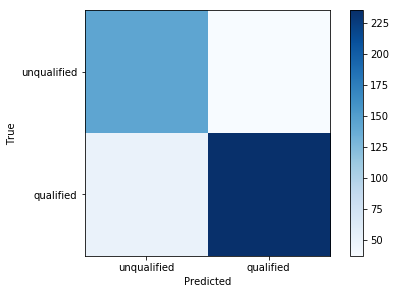

In [88]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    feed_dict_test = {inputs_: test_x,
                      labels_: test_y,}
    #prediction = sess.run(predicted, feed_dict=feed).squeeze
    #prediction = sess.run(predicted, feed_dict=feed)
    #y_pred_cls = tf.argmax(y_pred, dimension=1)
    #print(prediction.shape)
    print_confusion_matrix()

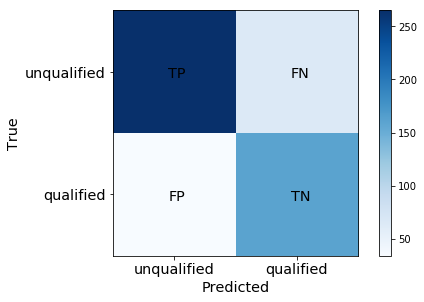

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
cm=np.array([[265,65],[34,161]])

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

# Make various adjustments to the plot.

plt.tight_layout()
plt.colorbar()
plt.xticks(np.arange(2),('unqualified','qualified'), fontsize='x-large')
plt.yticks(np.arange(2),('unqualified','qualified'), fontsize='x-large')
plt.xlabel('Predicted',fontsize='x-large')
plt.ylabel('True', fontsize='x-large')
plt.text(-0.05, 0.05, 'TP',fontsize='x-large')
plt.text(0.95, 0.05, 'FN',fontsize='x-large')
plt.text(-0.05, 1.05, 'FP',fontsize='x-large')
plt.text(0.95, 1.05, 'TN',fontsize='x-large')

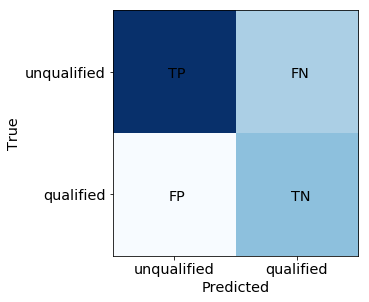

In [97]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
cm=np.array([[214,116],[67,128]])

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

# Make various adjustments to the plot.

plt.tight_layout()
#plt.colorbar(ticks=np.array([100,150,200,500]))
#,ticklabels=(('50', '100', '150', '200', '250'))
plt.xticks(np.arange(2),('unqualified','qualified'), fontsize='x-large')
plt.yticks(np.arange(2),('unqualified','qualified'), fontsize='x-large')
plt.xlabel('Predicted',fontsize='x-large')
plt.ylabel('True', fontsize='x-large')
plt.text(-0.05, 0.05, 'TP',fontsize='x-large')
plt.text(0.95, 0.05, 'FN',fontsize='x-large')
plt.text(-0.05, 1.05, 'FP',fontsize='x-large')
plt.text(0.95, 1.05, 'TN',fontsize='x-large')

In [91]:
print(np.linspace(0,250,))

[   0.           83.33333333  166.66666667  250.        ]


In [126]:
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.ndimage import imread

用训练好的网络测试图片

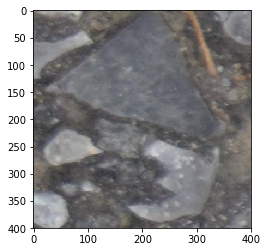

In [127]:
test_img_path = 'pavement/0/89.jpg'
test_img = imread(test_img_path)
plt.imshow(test_img)

In [128]:
# Run this cell if you don't have a vgg graph built 有codes之后跳过的那一步，就把vgg graph built跳过去了。所以这一步还要再跑一次
with tf.Session() as sess:
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    vgg = vgg16.Vgg16()
    vgg.build(input_)

G:\git_cache\抗滑\tensorflow_vgg\vgg16.npy
npy file loaded
build model started
build model finished: 1s


In [129]:
with tf.Session() as sess:
    img = utils.load_image(test_img_path)
    img = img.reshape((1, 224, 224, 3))

    feed_dict = {input_: img}
    code = sess.run(vgg.relu6, feed_dict=feed_dict)#把img变成code
        
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))#读取训练好的网络
    
    feed = {inputs_: code}#用code训练
    prediction = sess.run(predicted, feed_dict=feed).squeeze#预测()

INFO:tensorflow:Restoring parameters from checkpoints\pavement.ckpt


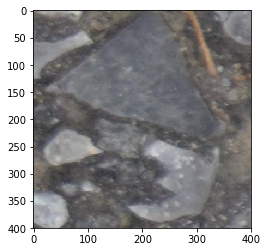

In [130]:
plt.imshow(test_img)

In [132]:
print(prediction)

[ 0.95318979  0.04681023]


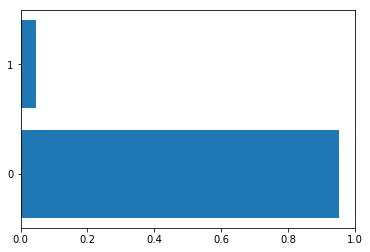

In [133]:
plt.barh(np.arange(2), prediction)
_ = plt.yticks(np.arange(2), lb.classes_)